# Coming from TensorFlow to NengoDL

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for people who are familiar with TensorFlow and looking to learn more about neuromorphic modelling with NengoDL.  For the other approach, users familiar with Nengo looking to learn how to use NengoDL, check out [this tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you would want to use it.  Nengo is a tool for constructing and simulating neural networks.  That is, to some extent, the same purpose as TensorFlow (and its higher level API, Keras).  For example, here is how we might build a simple two layer auto-encoder network in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net: 
    # input
    nengo_a = nengo.Node(np.zeros(n_in))
    
    # first layer
    nengo_b = nengo.Ensemble(
        n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())
    
    # second layer
    nengo_c = nengo.Ensemble(
        n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, 
        transform=nengo_dl.dists.Glorot())
    
    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and the creation of the connections between layers.  This is because the connection structure in Nengo networks often has a lot more state and general complexity than in typical deep learning networks, so it is helpful to be able to control it independently (we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we want to collect the activities of those neurons when the simulation is running.  You can think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality available, but we will focus on the features most familiar or relevant to those coming from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the Nengo-specific [documentation](https://www.nengo.ai/nengo/) and [examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.predict(np.ones((minibatch_size, n_in)));

Again, accomplishing the same thing in Nengo bears many similarities.  We create a `Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, 
                        minibatch_size=minibatch_size) as sim:
    sim.predict(np.ones((minibatch_size, 1, n_in)));

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#####         Constructing graph: build stage (9%)              | ETA: 0:00:00

|##############Constructing graph: build stage (72%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

One difference you may note is the extra dimension with size 1 in the shape of the Nengo inputs.  This represents the time dimension; in this example we're only running for a single timestep, which is why it has size 1, but this could be used to provide different input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an abstract set of computations, in Nengo we (almost) always think of the graph as representing a stateful neural simulation, where values are accumulated, updated, and communicated over time.  This is not to say there is no overlap (we can create TensorFlow simulations that execute over time, and we can create Nengo simulations without temporal dynamics), but this is a different way of thinking about computations that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic networks include features drawn from biological neural networks, in an effort to understand or recreate the functionality of biological brains.  Note that these models fall on a spectrum with standard artificial neural networks, with different approaches incorporating different biological features.  But in general the structure and parameterization of these networks often differs significantly from standard deep network architectures.

We touched on this above in the discussion of temporality, which is one common feature of neuromorphic networks.  Another common characteristic is the use of more complicated neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like `relu`) that output a continuous value, spiking neurons communicate via discrete bursts of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps` (or `sim.run`) is a standard Nengo Simulator execution function (as opposed to `sim.predict`, which is specific to NengoDL).  We could use either one, but you will probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in this case is that results will be stored in the `sim.data` dictionary, as opposed to being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|####          Constructing graph: build stage (7%)              | ETA: 0:00:00

|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

|  #                      Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

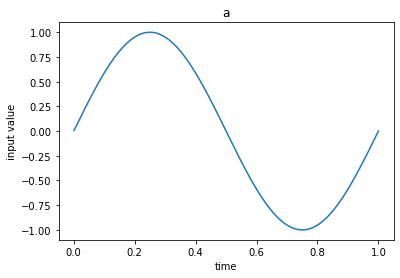

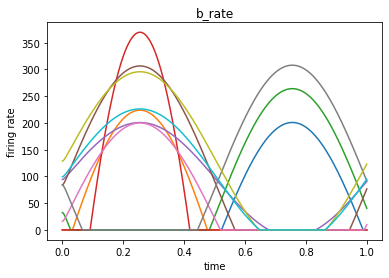

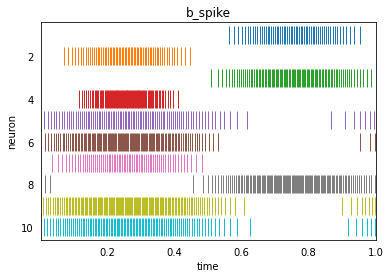

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    
    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(
        10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)
    
    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(
        10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)
    
    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)
    
with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input 
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")
    
plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike");

Each neuron responds to the input signal differently due to the random parameterization in the network (e.g. connection weights and biases).  We have matched the parameterization in the rate and spiking ensembles so that it is easier to see the parallels.

Note that the same information is being represented in the two ensembles.  For example, when the second neuron (orange) is outputting a high continuous value (in the second graph), the corresponding spiking neuron is outputting more discrete spikes (orange lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic filters.  This is inspired by a biological feature where discrete spikes induce a continuous electrical waveform in the receiving neuron, at the synapse (the point where the two neurons connect).  But computationally we can think of this simply as applying a filter to the spiking signal.

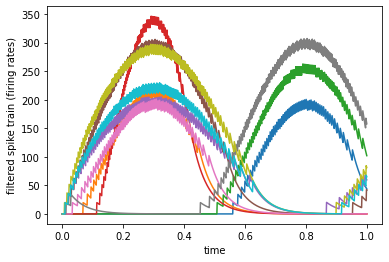

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)");

We can see how the spike trains, when viewed through a synaptic filter, approximate the continuous rate values in the second graph above.  

In this example we have computed the filtered signal manually for demonstration purposes, but in a typical Nengo model these synaptic filters are applied throughout the model, on the `Connection` objects.  For example, the above filtering would be equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and Nengo from a standard deep network background.  Although spiking neurons seem like a radically different paradigm, they can compute and communicate the same information as their rate counterparts.  But note that this only makes sense when we think of the network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete list).  These neuron models have various different behaviours, and managing their parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly work together.  Thus one important feature is the ability to write TensorFlow code directly, and insert it into a Nengo network.  This allows us to use whichever framework is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the rest of a Nengo model.  The TensorFlow code is written in a function that takes `tf.Tensors` as input, applies the desired manipulations through TensorFlow operations, and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose we want to apply batch normalization to the output of one of the Nengo ensembles.  There is no built-in way to do batch normalization in Nengo, so we can instead turn to TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(
        tf.keras.layers.BatchNormalization(momentum=0.9))(b_rate.neurons)
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`, except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this case, and we can add Probes or Connections to `batch_norm` in the same way as any other Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and `Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9), 
        shape_in=(10,), pass_time=False)
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the current simulation time and `x` is the value of any Connections incoming to the TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the `TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The `TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,) + shape_out`, where `shape_out` is the output dimensionality of the node (dependent on the manipulations applied to the inputs `x`).  We could explicitly specify `shape_out=(10,)` in the above example, or if we don't specify the output shape it will be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1]) 
    
    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)
        
        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)
        
    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), 
                            shape_out=(2,))
    nengo.Connection(a, b, synapse=None)
    
    p = nengo.Probe(b)
    
with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

TensorNode input:
t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation time over the 10 timesteps we executed, and `x` contains the value of the input Node that we connected to the TensorNode.  And we can see in the probe data that the TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This can be useful, for example, if the TensorNode requires internal parameters (which should be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:
    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))
        
        def call(self, inputs):
            return inputs * self.w
            
    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), 
                            pass_time=False)

More details on TensorNode usage can be found in [the user guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms, through the `Simulator.fit` function.  Returning to the autoencoder examples from the beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Train on 60000 samples
Epoch 1/2


   32/60000 [..............................] - ETA: 8:02 - loss: 6925.7021

  928/60000 [..............................] - ETA: 19s - loss: 4293.7797 

 1856/60000 [..............................] - ETA: 11s - loss: 3666.0767

 2784/60000 [>.............................] - ETA: 8s - loss: 3270.0497 

 3712/60000 [>.............................] - ETA: 7s - loss: 2992.6791

 4640/60000 [=>............................] - ETA: 6s - loss: 2801.9995

 5568/60000 [=>............................] - ETA: 5s - loss: 2642.3774

 6496/60000 [==>...........................] - ETA: 5s - loss: 2513.0270

 7424/60000 [==>...........................] - ETA: 4s - loss: 2405.8139

 8352/60000 [===>..........................] - ETA: 4s - loss: 2314.3966

 9248/60000 [===>..........................] - ETA: 4s - loss: 2236.5937

10176/60000 [====>.........................] - ETA: 4s - loss: 2167.8226

11104/60000 [====>.........................] - ETA: 3s - loss: 2105.8039

12032/60000 [=====>........................] - ETA: 3s - loss: 2051.2152

12960/60000 [=====>........................] - ETA: 3s - loss: 2001.3310

13888/60000 [=====>........................] - ETA: 3s - loss: 1955.4049

14784/60000 [======>.......................] - ETA: 3s - loss: 1916.1115

15680/60000 [======>.......................] - ETA: 3s - loss: 1879.4445

16608/60000 [=======>......................] - ETA: 3s - loss: 1844.3285

17536/60000 [=======>......................] - ETA: 2s - loss: 1812.6754

18432/60000 [========>.....................] - ETA: 2s - loss: 1781.7972

19360/60000 [========>.....................] - ETA: 2s - loss: 1752.7099

20288/60000 [=========>....................] - ETA: 2s - loss: 1728.3260

21216/60000 [=========>....................] - ETA: 2s - loss: 1705.0580

22144/60000 [==========>...................] - ETA: 2s - loss: 1682.0375

23072/60000 [==========>...................] - ETA: 2s - loss: 1661.4475

24000/60000 [===========>..................] - ETA: 2s - loss: 1640.0598

24928/60000 [===========>..................] - ETA: 2s - loss: 1621.1187

25824/60000 [===========>..................] - ETA: 2s - loss: 1603.2831

26752/60000 [============>.................] - ETA: 2s - loss: 1586.0392

27648/60000 [============>.................] - ETA: 2s - loss: 1570.4078

28544/60000 [=============>................] - ETA: 2s - loss: 1555.5818

29440/60000 [=============>................] - ETA: 1s - loss: 1541.4257

30336/60000 [==============>...............] - ETA: 1s - loss: 1528.0993

31264/60000 [==============>...............] - ETA: 1s - loss: 1514.0325

32160/60000 [===============>..............] - ETA: 1s - loss: 1500.9160

33088/60000 [===============>..............] - ETA: 1s - loss: 1488.4119

34016/60000 [================>.............] - ETA: 1s - loss: 1475.4087

34944/60000 [================>.............] - ETA: 1s - loss: 1462.6481

35872/60000 [================>.............] - ETA: 1s - loss: 1450.8903

36768/60000 [=================>............] - ETA: 1s - loss: 1440.4682

37696/60000 [=================>............] - ETA: 1s - loss: 1428.9664

38592/60000 [==================>...........] - ETA: 1s - loss: 1418.9067

39520/60000 [==================>...........] - ETA: 1s - loss: 1409.1168

40448/60000 [===================>..........] - ETA: 1s - loss: 1400.2454

41376/60000 [===================>..........] - ETA: 1s - loss: 1391.5221

42272/60000 [====================>.........] - ETA: 1s - loss: 1383.2739

43200/60000 [====================>.........] - ETA: 1s - loss: 1374.7657

44128/60000 [=====================>........] - ETA: 0s - loss: 1366.1766

45024/60000 [=====================>........] - ETA: 0s - loss: 1358.3951

45920/60000 [=====================>........] - ETA: 0s - loss: 1351.2211

46848/60000 [======================>.......] - ETA: 0s - loss: 1344.3408

47776/60000 [======================>.......] - ETA: 0s - loss: 1337.0390

48704/60000 [=======================>......] - ETA: 0s - loss: 1330.2056

49632/60000 [=======================>......] - ETA: 0s - loss: 1323.6616

50560/60000 [========================>.....] - ETA: 0s - loss: 1317.5122

51456/60000 [========================>.....] - ETA: 0s - loss: 1311.1386

52384/60000 [=========================>....] - ETA: 0s - loss: 1304.7242

53312/60000 [=========================>....] - ETA: 0s - loss: 1298.8834

54240/60000 [==========================>...] - ETA: 0s - loss: 1292.8658

55136/60000 [==========================>...] - ETA: 0s - loss: 1287.3279

56032/60000 [===========================>..] - ETA: 0s - loss: 1281.7416

56960/60000 [===========================>..] - ETA: 0s - loss: 1276.4544

57888/60000 [===========================>..] - ETA: 0s - loss: 1271.0129

58816/60000 [============================>.] - ETA: 0s - loss: 1265.8259

59744/60000 [============================>.] - ETA: 0s - loss: 1260.7637

60000/60000 [==============================] - 4s 60us/sample - loss: 1259.2277


Epoch 2/2
   32/60000 [..............................] - ETA: 3s - loss: 1000.1483

  960/60000 [..............................] - ETA: 3s - loss: 924.3327 

 1888/60000 [..............................] - ETA: 3s - loss: 935.3195

 2816/60000 [>.............................] - ETA: 3s - loss: 925.4796

 3744/60000 [>.............................] - ETA: 3s - loss: 929.0537

 4640/60000 [=>............................] - ETA: 3s - loss: 932.2365

 5568/60000 [=>............................] - ETA: 3s - loss: 927.2008

 6496/60000 [==>...........................] - ETA: 2s - loss: 927.9307

 7424/60000 [==>...........................] - ETA: 2s - loss: 932.6266

 8352/60000 [===>..........................] - ETA: 2s - loss: 930.2683

 9280/60000 [===>..........................] - ETA: 2s - loss: 929.5450

10208/60000 [====>.........................] - ETA: 2s - loss: 928.9211

11072/60000 [====>.........................] - ETA: 2s - loss: 926.9791

11968/60000 [====>.........................] - ETA: 2s - loss: 926.6594

12896/60000 [=====>........................] - ETA: 2s - loss: 925.1202

13792/60000 [=====>........................] - ETA: 2s - loss: 925.4774

14720/60000 [======>.......................] - ETA: 2s - loss: 926.2990

15648/60000 [======>.......................] - ETA: 2s - loss: 925.2811

16576/60000 [=======>......................] - ETA: 2s - loss: 925.2824

17504/60000 [=======>......................] - ETA: 2s - loss: 925.6013

18432/60000 [========>.....................] - ETA: 2s - loss: 924.3331

19360/60000 [========>.....................] - ETA: 2s - loss: 924.2675

20288/60000 [=========>....................] - ETA: 2s - loss: 923.0593

21216/60000 [=========>....................] - ETA: 2s - loss: 922.5708

22144/60000 [==========>...................] - ETA: 2s - loss: 922.0149

23008/60000 [==========>...................] - ETA: 2s - loss: 922.7008

23936/60000 [==========>...................] - ETA: 2s - loss: 921.3020

24864/60000 [===========>..................] - ETA: 1s - loss: 920.5890

25792/60000 [===========>..................] - ETA: 1s - loss: 919.8441

26720/60000 [============>.................] - ETA: 1s - loss: 919.1517

27648/60000 [============>.................] - ETA: 1s - loss: 919.0773

28544/60000 [=============>................] - ETA: 1s - loss: 918.5427

29472/60000 [=============>................] - ETA: 1s - loss: 916.6849

30368/60000 [==============>...............] - ETA: 1s - loss: 915.9050

31104/60000 [==============>...............] - ETA: 1s - loss: 914.9069

31936/60000 [==============>...............] - ETA: 1s - loss: 914.6227

32832/60000 [===============>..............] - ETA: 1s - loss: 914.1054

33728/60000 [===============>..............] - ETA: 1s - loss: 913.1550

34624/60000 [================>.............] - ETA: 1s - loss: 913.3024

35520/60000 [================>.............] - ETA: 1s - loss: 913.9835

36448/60000 [=================>............] - ETA: 1s - loss: 913.9573

37344/60000 [=================>............] - ETA: 1s - loss: 912.9154

38240/60000 [==================>...........] - ETA: 1s - loss: 912.4624

39136/60000 [==================>...........] - ETA: 1s - loss: 911.9605

40032/60000 [===================>..........] - ETA: 1s - loss: 912.5891

40960/60000 [===================>..........] - ETA: 1s - loss: 911.8528

41888/60000 [===================>..........] - ETA: 1s - loss: 911.2561

42816/60000 [====================>.........] - ETA: 0s - loss: 911.2447

43744/60000 [====================>.........] - ETA: 0s - loss: 910.5565

44672/60000 [=====================>........] - ETA: 0s - loss: 910.3849

45600/60000 [=====================>........] - ETA: 0s - loss: 910.1649

46528/60000 [======================>.......] - ETA: 0s - loss: 909.6386

47456/60000 [======================>.......] - ETA: 0s - loss: 909.8133

48384/60000 [=======================>......] - ETA: 0s - loss: 909.3117

49312/60000 [=======================>......] - ETA: 0s - loss: 909.4579

50208/60000 [========================>.....] - ETA: 0s - loss: 909.1071

51072/60000 [========================>.....] - ETA: 0s - loss: 908.4055

52000/60000 [=========================>....] - ETA: 0s - loss: 907.3540

52896/60000 [=========================>....] - ETA: 0s - loss: 906.6413

53824/60000 [=========================>....] - ETA: 0s - loss: 906.3911

54752/60000 [==========================>...] - ETA: 0s - loss: 905.8154

55680/60000 [==========================>...] - ETA: 0s - loss: 905.8448

56608/60000 [===========================>..] - ETA: 0s - loss: 905.7435

57536/60000 [===========================>..] - ETA: 0s - loss: 905.5583

58432/60000 [============================>.] - ETA: 0s - loss: 904.9889

59328/60000 [============================>.] - ETA: 0s - loss: 904.1411

60000/60000 [==============================] - 3s 56us/sample - loss: 903.7612


10000/10000 - 0s - loss: 853.6339


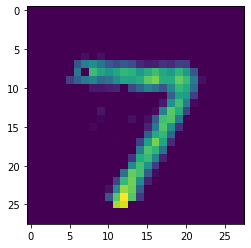

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
              loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data, verbose=2)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)));

Before running the same training in NengoDL, we'll change the Nengo model parameters to more closely match the TensorFlow network (we omitted these details in the original presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are essentially temporal, so data is described over time (indicating what the inputs/targets should be on each simulation timestep).  So instead of the data having shape `(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll just be training for a single timestep, but we still need to add that extra axis with length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Train on 60000 samples
Epoch 1/2


   50/60000 [..............................] - ETA: 4:25 - loss: 7597.9155 - probe_loss: 7597.9155

  800/60000 [..............................] - ETA: 20s - loss: 4726.5043 - probe_loss: 4726.5039 

 1550/60000 [..............................] - ETA: 12s - loss: 4126.4836 - probe_loss: 4126.4834

 2300/60000 [>.............................] - ETA: 9s - loss: 3750.1813 - probe_loss: 3750.1816 

 3050/60000 [>.............................] - ETA: 8s - loss: 3497.4713 - probe_loss: 3497.4717

 3800/60000 [>.............................] - ETA: 7s - loss: 3283.8381 - probe_loss: 3283.8379

 4550/60000 [=>............................] - ETA: 6s - loss: 3117.4479 - probe_loss: 3117.4478

 5300/60000 [=>............................] - ETA: 6s - loss: 2976.4308 - probe_loss: 2976.4307

 6050/60000 [==>...........................] - ETA: 5s - loss: 2863.7992 - probe_loss: 2863.7993

 6750/60000 [==>...........................] - ETA: 5s - loss: 2766.4905 - probe_loss: 2766.4910

 7300/60000 [==>...........................] - ETA: 5s - loss: 2697.3531 - probe_loss: 2697.3535

 8000/60000 [===>..........................] - ETA: 5s - loss: 2618.1844 - probe_loss: 2618.1851

 8750/60000 [===>..........................] - ETA: 4s - loss: 2546.5598 - probe_loss: 2546.5608

 9500/60000 [===>..........................] - ETA: 4s - loss: 2482.0745 - probe_loss: 2482.0754

10250/60000 [====>.........................] - ETA: 4s - loss: 2421.0907 - probe_loss: 2421.0913

11000/60000 [====>.........................] - ETA: 4s - loss: 2367.4769 - probe_loss: 2367.4775

11750/60000 [====>.........................] - ETA: 4s - loss: 2317.8661 - probe_loss: 2317.8665

12500/60000 [=====>........................] - ETA: 4s - loss: 2274.3523 - probe_loss: 2274.3530

13200/60000 [=====>........................] - ETA: 4s - loss: 2237.5779 - probe_loss: 2237.5784

13900/60000 [=====>........................] - ETA: 4s - loss: 2201.8788 - probe_loss: 2201.8789

14650/60000 [======>.......................] - ETA: 3s - loss: 2163.9914 - probe_loss: 2163.9919

15400/60000 [======>.......................] - ETA: 3s - loss: 2130.7453 - probe_loss: 2130.7458

16150/60000 [=======>......................] - ETA: 3s - loss: 2099.2539 - probe_loss: 2099.2542

16900/60000 [=======>......................] - ETA: 3s - loss: 2068.6982 - probe_loss: 2068.6985

17650/60000 [=======>......................] - ETA: 3s - loss: 2039.6900 - probe_loss: 2039.6903

18400/60000 [========>.....................] - ETA: 3s - loss: 2013.7989 - probe_loss: 2013.7992

19150/60000 [========>.....................] - ETA: 3s - loss: 1989.1533 - probe_loss: 1989.1536

19900/60000 [========>.....................] - ETA: 3s - loss: 1966.2482 - probe_loss: 1966.2485

20650/60000 [=========>....................] - ETA: 3s - loss: 1944.0415 - probe_loss: 1944.0421

21400/60000 [=========>....................] - ETA: 3s - loss: 1923.8320 - probe_loss: 1923.8324

22150/60000 [==========>...................] - ETA: 3s - loss: 1904.9263 - probe_loss: 1904.9265

22900/60000 [==========>...................] - ETA: 2s - loss: 1886.3222 - probe_loss: 1886.3221

23650/60000 [==========>...................] - ETA: 2s - loss: 1867.1674 - probe_loss: 1867.1676

24400/60000 [===========>..................] - ETA: 2s - loss: 1849.4746 - probe_loss: 1849.4747

25150/60000 [===========>..................] - ETA: 2s - loss: 1832.0406 - probe_loss: 1832.0409

25900/60000 [===========>..................] - ETA: 2s - loss: 1815.5266 - probe_loss: 1815.5269

26650/60000 [============>.................] - ETA: 2s - loss: 1801.2347 - probe_loss: 1801.2354

27250/60000 [============>.................] - ETA: 2s - loss: 1788.1348 - probe_loss: 1788.1354

27900/60000 [============>.................] - ETA: 2s - loss: 1775.3480 - probe_loss: 1775.3486

28650/60000 [=============>................] - ETA: 2s - loss: 1761.0210 - probe_loss: 1761.0216

29400/60000 [=============>................] - ETA: 2s - loss: 1748.3921 - probe_loss: 1748.3929

30150/60000 [==============>...............] - ETA: 2s - loss: 1735.5938 - probe_loss: 1735.5945

30900/60000 [==============>...............] - ETA: 2s - loss: 1722.1704 - probe_loss: 1722.1713

31650/60000 [==============>...............] - ETA: 2s - loss: 1709.8716 - probe_loss: 1709.8724

32400/60000 [===============>..............] - ETA: 2s - loss: 1698.4623 - probe_loss: 1698.4635

33150/60000 [===============>..............] - ETA: 2s - loss: 1687.4989 - probe_loss: 1687.5000

33900/60000 [===============>..............] - ETA: 2s - loss: 1676.8428 - probe_loss: 1676.8439

34650/60000 [================>.............] - ETA: 1s - loss: 1666.6496 - probe_loss: 1666.6503

35400/60000 [================>.............] - ETA: 1s - loss: 1656.5257 - probe_loss: 1656.5264

36150/60000 [=================>............] - ETA: 1s - loss: 1646.6882 - probe_loss: 1646.6891

36900/60000 [=================>............] - ETA: 1s - loss: 1636.6116 - probe_loss: 1636.6122

37650/60000 [=================>............] - ETA: 1s - loss: 1627.9711 - probe_loss: 1627.9716

38400/60000 [==================>...........] - ETA: 1s - loss: 1618.6142 - probe_loss: 1618.6146

39100/60000 [==================>...........] - ETA: 1s - loss: 1610.5600 - probe_loss: 1610.5605

39850/60000 [==================>...........] - ETA: 1s - loss: 1601.7077 - probe_loss: 1601.7081

40600/60000 [===================>..........] - ETA: 1s - loss: 1593.3488 - probe_loss: 1593.3492

41350/60000 [===================>..........] - ETA: 1s - loss: 1585.9335 - probe_loss: 1585.9341

42050/60000 [====================>.........] - ETA: 1s - loss: 1579.1501 - probe_loss: 1579.1508

42800/60000 [====================>.........] - ETA: 1s - loss: 1571.2007 - probe_loss: 1571.2014

43550/60000 [====================>.........] - ETA: 1s - loss: 1564.1589 - probe_loss: 1564.1598

44300/60000 [=====================>........] - ETA: 1s - loss: 1556.9360 - probe_loss: 1556.9369

45000/60000 [=====================>........] - ETA: 1s - loss: 1549.7968 - probe_loss: 1549.7976

45750/60000 [=====================>........] - ETA: 1s - loss: 1543.4005 - probe_loss: 1543.4015

46450/60000 [======================>.......] - ETA: 1s - loss: 1536.9509 - probe_loss: 1536.9518

47200/60000 [======================>.......] - ETA: 0s - loss: 1530.3649 - probe_loss: 1530.3660

47950/60000 [======================>.......] - ETA: 0s - loss: 1524.2400 - probe_loss: 1524.2411

48700/60000 [=======================>......] - ETA: 0s - loss: 1518.6157 - probe_loss: 1518.6171

49400/60000 [=======================>......] - ETA: 0s - loss: 1513.1130 - probe_loss: 1513.1143

50150/60000 [========================>.....] - ETA: 0s - loss: 1506.8807 - probe_loss: 1506.8821

50900/60000 [========================>.....] - ETA: 0s - loss: 1501.2790 - probe_loss: 1501.2803

51650/60000 [========================>.....] - ETA: 0s - loss: 1495.9721 - probe_loss: 1495.9733

52400/60000 [=========================>....] - ETA: 0s - loss: 1490.4410 - probe_loss: 1490.4420

53150/60000 [=========================>....] - ETA: 0s - loss: 1485.2357 - probe_loss: 1485.2366

53900/60000 [=========================>....] - ETA: 0s - loss: 1479.6881 - probe_loss: 1479.6888

54650/60000 [==========================>...] - ETA: 0s - loss: 1474.2419 - probe_loss: 1474.2426

55400/60000 [==========================>...] - ETA: 0s - loss: 1468.6933 - probe_loss: 1468.6942

56150/60000 [===========================>..] - ETA: 0s - loss: 1464.1728 - probe_loss: 1464.1736

56900/60000 [===========================>..] - ETA: 0s - loss: 1458.7216 - probe_loss: 1458.7223

57650/60000 [===========================>..] - ETA: 0s - loss: 1453.9842 - probe_loss: 1453.9849

58400/60000 [============================>.] - ETA: 0s - loss: 1449.2561 - probe_loss: 1449.2566

59150/60000 [============================>.] - ETA: 0s - loss: 1444.7252 - probe_loss: 1444.7256

59900/60000 [============================>.] - ETA: 0s - loss: 1439.8451 - probe_loss: 1439.8455

60000/60000 [==============================] - 4s 74us/sample - loss: 1439.3277 - probe_loss: 1439.3281


Epoch 2/2
   50/60000 [..............................] - ETA: 6s - loss: 1075.2164 - probe_loss: 1075.2164

  800/60000 [..............................] - ETA: 4s - loss: 1099.9666 - probe_loss: 1099.9666

 1550/60000 [..............................] - ETA: 4s - loss: 1095.1320 - probe_loss: 1095.1321

 2300/60000 [>.............................] - ETA: 4s - loss: 1101.2887 - probe_loss: 1101.2887

 3050/60000 [>.............................] - ETA: 3s - loss: 1089.9809 - probe_loss: 1089.9808

 3800/60000 [>.............................] - ETA: 3s - loss: 1091.3307 - probe_loss: 1091.3304

 4550/60000 [=>............................] - ETA: 3s - loss: 1087.1410 - probe_loss: 1087.1407

 5300/60000 [=>............................] - ETA: 3s - loss: 1083.6569 - probe_loss: 1083.6567

 6050/60000 [==>...........................] - ETA: 3s - loss: 1083.9470 - probe_loss: 1083.9469

 6800/60000 [==>...........................] - ETA: 3s - loss: 1084.9742 - probe_loss: 1084.9741

 7550/60000 [==>...........................] - ETA: 3s - loss: 1081.6485 - probe_loss: 1081.6484

 8300/60000 [===>..........................] - ETA: 3s - loss: 1082.7471 - probe_loss: 1082.7469

 9050/60000 [===>..........................] - ETA: 3s - loss: 1082.4669 - probe_loss: 1082.4668

 9800/60000 [===>..........................] - ETA: 3s - loss: 1079.6517 - probe_loss: 1079.6516

10500/60000 [====>.........................] - ETA: 3s - loss: 1077.3837 - probe_loss: 1077.3837

11250/60000 [====>.........................] - ETA: 3s - loss: 1076.5205 - probe_loss: 1076.5204

11950/60000 [====>.........................] - ETA: 3s - loss: 1075.1616 - probe_loss: 1075.1614

12700/60000 [=====>........................] - ETA: 3s - loss: 1073.8397 - probe_loss: 1073.8396

13450/60000 [=====>........................] - ETA: 3s - loss: 1073.0843 - probe_loss: 1073.0844

14200/60000 [======>.......................] - ETA: 3s - loss: 1071.1812 - probe_loss: 1071.1812

14950/60000 [======>.......................] - ETA: 3s - loss: 1069.0199 - probe_loss: 1069.0200

15700/60000 [======>.......................] - ETA: 3s - loss: 1066.9823 - probe_loss: 1066.9825

16450/60000 [=======>......................] - ETA: 3s - loss: 1064.4126 - probe_loss: 1064.4128

17200/60000 [=======>......................] - ETA: 2s - loss: 1064.8333 - probe_loss: 1064.8336

17900/60000 [=======>......................] - ETA: 2s - loss: 1062.8741 - probe_loss: 1062.8744

18650/60000 [========>.....................] - ETA: 2s - loss: 1061.9078 - probe_loss: 1061.9080

19400/60000 [========>.....................] - ETA: 2s - loss: 1061.0704 - probe_loss: 1061.0706

20150/60000 [=========>....................] - ETA: 2s - loss: 1060.1574 - probe_loss: 1060.1575

20900/60000 [=========>....................] - ETA: 2s - loss: 1058.8386 - probe_loss: 1058.8386

21650/60000 [=========>....................] - ETA: 2s - loss: 1057.6363 - probe_loss: 1057.6362

22400/60000 [==========>...................] - ETA: 2s - loss: 1057.3937 - probe_loss: 1057.3939

23050/60000 [==========>...................] - ETA: 2s - loss: 1056.2091 - probe_loss: 1056.2094

23800/60000 [==========>...................] - ETA: 2s - loss: 1054.0050 - probe_loss: 1054.0051

24550/60000 [===========>..................] - ETA: 2s - loss: 1053.5883 - probe_loss: 1053.5886

25250/60000 [===========>..................] - ETA: 2s - loss: 1052.6885 - probe_loss: 1052.6887

26000/60000 [============>.................] - ETA: 2s - loss: 1052.7370 - probe_loss: 1052.7373

26750/60000 [============>.................] - ETA: 2s - loss: 1052.9833 - probe_loss: 1052.9838

27500/60000 [============>.................] - ETA: 2s - loss: 1052.3836 - probe_loss: 1052.3840

28250/60000 [=============>................] - ETA: 2s - loss: 1051.5258 - probe_loss: 1051.5264

29000/60000 [=============>................] - ETA: 2s - loss: 1050.4030 - probe_loss: 1050.4036

29750/60000 [=============>................] - ETA: 2s - loss: 1049.7586 - probe_loss: 1049.7593

30500/60000 [==============>...............] - ETA: 2s - loss: 1048.8773 - probe_loss: 1048.8779

31250/60000 [==============>...............] - ETA: 2s - loss: 1048.1955 - probe_loss: 1048.1960

31950/60000 [==============>...............] - ETA: 1s - loss: 1047.5987 - probe_loss: 1047.5995

32700/60000 [===============>..............] - ETA: 1s - loss: 1047.3587 - probe_loss: 1047.3594

33450/60000 [===============>..............] - ETA: 1s - loss: 1046.5229 - probe_loss: 1046.5237

34200/60000 [================>.............] - ETA: 1s - loss: 1046.6987 - probe_loss: 1046.6993

34950/60000 [================>.............] - ETA: 1s - loss: 1046.3442 - probe_loss: 1046.3448

35700/60000 [================>.............] - ETA: 1s - loss: 1044.9296 - probe_loss: 1044.9302

36450/60000 [=================>............] - ETA: 1s - loss: 1045.6793 - probe_loss: 1045.6798

37200/60000 [=================>............] - ETA: 1s - loss: 1044.6219 - probe_loss: 1044.6221

37950/60000 [=================>............] - ETA: 1s - loss: 1044.3180 - probe_loss: 1044.3182

38700/60000 [==================>...........] - ETA: 1s - loss: 1043.5705 - probe_loss: 1043.5706

39400/60000 [==================>...........] - ETA: 1s - loss: 1042.4627 - probe_loss: 1042.4628

40150/60000 [===================>..........] - ETA: 1s - loss: 1042.0284 - probe_loss: 1042.0284

40850/60000 [===================>..........] - ETA: 1s - loss: 1041.4376 - probe_loss: 1041.4376

41550/60000 [===================>..........] - ETA: 1s - loss: 1041.0140 - probe_loss: 1041.0139

42300/60000 [====================>.........] - ETA: 1s - loss: 1039.8958 - probe_loss: 1039.8959

43050/60000 [====================>.........] - ETA: 1s - loss: 1040.1080 - probe_loss: 1040.1080

43800/60000 [====================>.........] - ETA: 1s - loss: 1039.3832 - probe_loss: 1039.3833

44550/60000 [=====================>........] - ETA: 1s - loss: 1038.5969 - probe_loss: 1038.5970

45300/60000 [=====================>........] - ETA: 1s - loss: 1037.1883 - probe_loss: 1037.1885

46050/60000 [======================>.......] - ETA: 0s - loss: 1036.2259 - probe_loss: 1036.2260

46750/60000 [======================>.......] - ETA: 0s - loss: 1034.8799 - probe_loss: 1034.8800

47500/60000 [======================>.......] - ETA: 0s - loss: 1033.7760 - probe_loss: 1033.7761

48250/60000 [=======================>......] - ETA: 0s - loss: 1032.8125 - probe_loss: 1032.8127

49000/60000 [=======================>......] - ETA: 0s - loss: 1031.8608 - probe_loss: 1031.8611

49750/60000 [=======================>......] - ETA: 0s - loss: 1031.1384 - probe_loss: 1031.1388

50500/60000 [========================>.....] - ETA: 0s - loss: 1030.6376 - probe_loss: 1030.6379

51250/60000 [========================>.....] - ETA: 0s - loss: 1029.8507 - probe_loss: 1029.8512

52000/60000 [=========================>....] - ETA: 0s - loss: 1028.5910 - probe_loss: 1028.5916

52750/60000 [=========================>....] - ETA: 0s - loss: 1027.7631 - probe_loss: 1027.7637

53500/60000 [=========================>....] - ETA: 0s - loss: 1027.0390 - probe_loss: 1027.0396

54200/60000 [==========================>...] - ETA: 0s - loss: 1026.3694 - probe_loss: 1026.3701

54800/60000 [==========================>...] - ETA: 0s - loss: 1026.1004 - probe_loss: 1026.1012

55550/60000 [==========================>...] - ETA: 0s - loss: 1025.4537 - probe_loss: 1025.4543

56300/60000 [===========================>..] - ETA: 0s - loss: 1024.5268 - probe_loss: 1024.5273

57050/60000 [===========================>..] - ETA: 0s - loss: 1023.6958 - probe_loss: 1023.6964

57650/60000 [===========================>..] - ETA: 0s - loss: 1023.3678 - probe_loss: 1023.3685

58400/60000 [============================>.] - ETA: 0s - loss: 1022.9698 - probe_loss: 1022.9705

59150/60000 [============================>.] - ETA: 0s - loss: 1022.5076 - probe_loss: 1022.5081

59900/60000 [============================>.] - ETA: 0s - loss: 1021.5961 - probe_loss: 1021.5966

60000/60000 [==============================] - 4s 70us/sample - loss: 1021.4577 - probe_loss: 1021.4583


10000/10000 - 1s - loss: 942.3655 - probe_loss: 942.3653


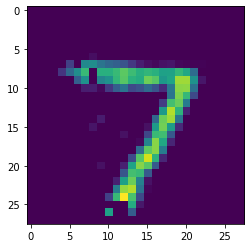

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), 
                loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data, verbose=2)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)));

More details on using `sim.fit` can be found in [the user guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering Framework (NEF).  This uses linear least-squares optimization to solve for optimal connection weights analytically, rather than using an iterative gradient-descent based algorithm.  The advantage of the NEF is that it is very fast and general (for example, it does not require the network to be differentiable).  The disadvantage is that it optimizes each set of connection weights individually (i.e., it cannot jointly optimize across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a `nengo.Connection`.  This specifies the function that we would like those connection weights to approximate.  In addition, in previous examples you may have noticed that we were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using `ensemble.neurons` specifies that we want to form a direct connection between ensemble neurons, without applying the NEF optimization.  So when we want to use the `function` argument, the `Connection` source object should be an `ensemble`, not `ensemble.neurons`.  For example, we could use the NEF to create a network to approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|######        Constructing graph: build stage (10%)             | ETA: 0:00:00

|##############Constructing graph: build stage (60%)             | ETA: 0:00:00

|##############Constructing graph: build stage (90%)######       | ETA: 0:00:00

|   #                     Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

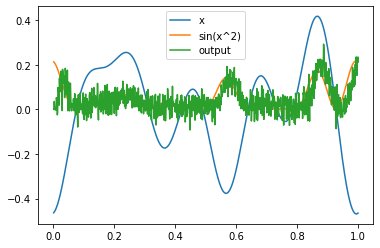

In [17]:
with nengo.Network(seed=0) as net:    
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))
    
    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)
    
    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)
    
    # output node
    outpt = nengo.Node(size_in=1)
    
    # connect input to first ensemble
    nengo.Connection(inpt, ens0)
    
    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)
    
    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)
    
    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt)
    
with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

The NEF optimization can be used in combination with the deep learning optimization methods.  For example, we could optimize some parameters with the NEF and others with `sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).  Or we could initialize each set of connection weights individually with the NEF, and then further refine them with end-to-end training via `sim.fit`.  As always, the overall theme is that NengoDL allows us to use whichever method is most appropriate for a particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic networks quickly/efficiently.  However, often it is difficult to program this custom hardware, and it requires writing custom code for each neuromorphic platform.  One of the primary design goals of Nengo is to alleviate these challenges, by providing a single API that can be used to build networks across many different neuromorphic platforms.  

The idea is that the front-end network construction code is the same (`Networks`, `Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own `Simulator` class (the back-end) that compiles and executes that network definition for some compute platform.  This provides a consistent interface so that we only need to write code once and can then run that network on novel hardware platforms with no additional effort.  For example, we could take the network from above and simulate it on different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

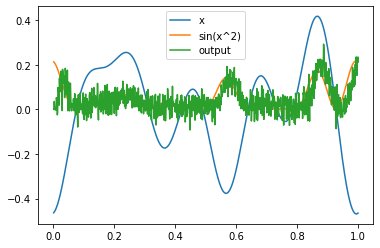

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)
    
# run on Loihi neuromorphic hardware 
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware 
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)
    
# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p]**2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend();

We have commented out the different backends above because they require extra installation steps, but if you are running this example yourself you can install any of those backends (or more) and uncomment that code to see the same network running on that new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end (among other things); it takes a standard Nengo network, and simulates it using TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate NengoDL's deep learning functionality into any other Nengo back-end.  We build our Network, optimize it in NengoDL, save the optimized model parameters back into the Network definition, and then simulate that optimized Network in a different back-end.  See [this example in nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL, including network construction, execution, and optimization.  We have also discussed how to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the unique features of Nengo (such as NEF optimization and neuromorphic cross-platform execution).  However, there is much more functionality in NengoDL than we are able to introduce here; check out the [user guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you would like more information on how NengoDL is implemented under the hood using TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).